### Import


In [1]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, classification_report

from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from cnn_classifier import CNN

import pandas as pd
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

import time



### Load dataset

In [2]:
dataset = np.load("dataset.npz")
X, y = dataset["X"], dataset["y"]

Label for image 10: 3


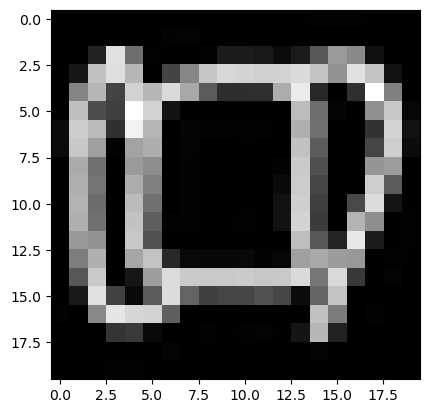

In [3]:
k=10
shape = (X[k].reshape(20,20))
flatten = shape.flatten()

print(f"Label for image {k}: {y[k]}")
plt.imshow(shape, vmin=0, vmax=255, cmap="gray")
plt.show()

In [4]:
random_state = 42
scaler = StandardScaler()

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=random_state
)

X_trainval_tensor = torch.tensor(X_trainval, dtype=torch.float32)
y_trainval_tensor = torch.tensor(y_trainval, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

print("Unique labels:", np.unique(y_trainval))

Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


## Class distribution

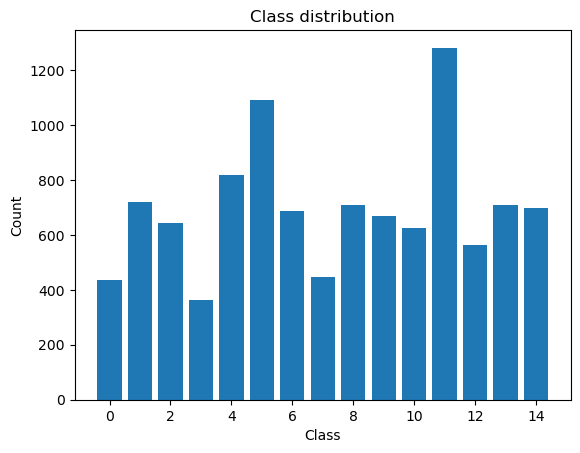

In [5]:
def class_dist(y):
    unique, counts = np.unique(y, return_counts=True)
    plt.bar(unique, counts)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.title("Class distribution")
    plt.show()
class_dist(y_trainval)

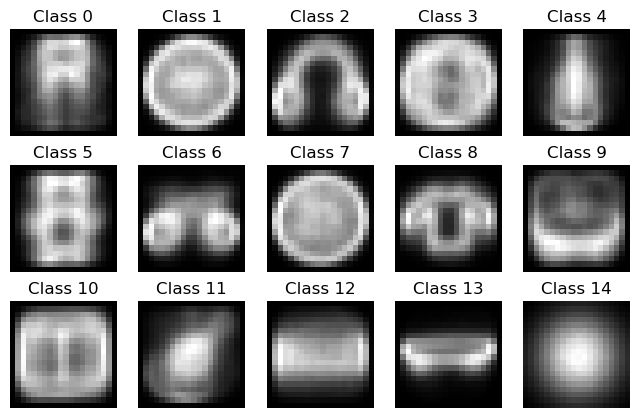

In [6]:
def blurred():
    means = []
    for label in range(15):
        means.append(X_trainval[y_trainval == label].mean(axis=0))

    fig, axes = plt.subplots(3, 5, figsize=(8, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(means[i].reshape(20, 20), cmap='gray')
        ax.set_title(f"Class {i}")
        ax.axis('off')
    plt.show()

blurred()

# CNN

In [ ]:
pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('cnn', CNN())
        ])

param_grid = {
   "cnn__learning_rate": [0.001, 0.0005],
   "cnn__dropout_rate": [0.25, 0.5],
   "cnn__batch_size": [32, 64],
   "cnn__weight_decay": [0, 1e-4],
   "cnn__random_state": [random_state]
}

grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=3)
grid.fit(X_trainval, y_trainval)

In [19]:
print("Best parameters:", grid.best_params_)
best_model = grid.best_estimator_["cnn"]
best_model_scaler = grid.best_estimator_["scaler"]

Best parameters: {'cnn__batch_size': 32, 'cnn__dropout_rate': 0.5, 'cnn__learning_rate': 0.001, 'cnn__random_state': 42, 'cnn__weight_decay': 0}


In [9]:
X_test = best_model_scaler.transform(X_test)
test_acc = best_model.compute_accuracy(X_test, y_test)
y_pred = best_model.predict(X_test)
test_f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\nTest Accuracy: {test_acc * 100:.2f}%")
print(f"Weighted F1-score: {test_f1:.4f}")
print(classification_report(y_test, y_pred))


Test Accuracy: 83.74%
Weighted F1-score: 0.8377
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       109
           1       0.71      0.76      0.74       180
           2       0.94      0.93      0.93       161
           3       0.76      0.62      0.68        91
           4       0.59      0.67      0.63       204
           5       0.95      0.89      0.92       273
           6       0.95      0.93      0.94       172
           7       0.77      0.66      0.71       111
           8       0.93      0.96      0.94       178
           9       0.88      0.86      0.87       167
          10       0.89      0.88      0.88       156
          11       0.73      0.70      0.72       320
          12       0.77      0.86      0.81       140
          13       0.89      0.94      0.91       177
          14       1.00      1.00      1.00       175

    accuracy                           0.84      2614
   macro avg       0.84      0.

##### Plotting Training Loss

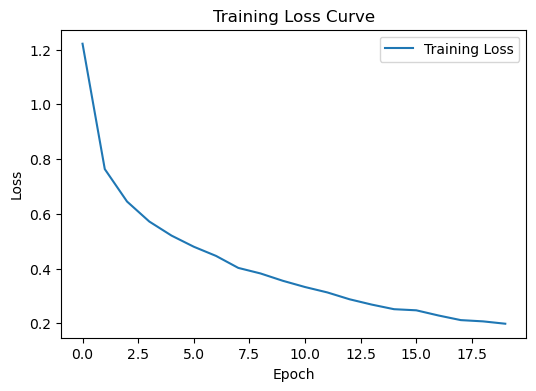

In [10]:
plt.figure(figsize=(6,4))
plt.plot(best_model.train_loss_history, label='Training Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training Loss Curve')
plt.legend()
plt.show()

# KNN

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

param_grid_knn = {
    'classifier__n_neighbors': [2, 3, 4, 5, 6, 7],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev']
}

param_grid_pca = {
    'pca__n_components': [0.70, 0.80, 0.90, 0.95]
}

def choose_pipeline(classifier, pca=False):
    if pca:
        return Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=0.95)),
            ('classifier', classifier)
        ])
    else:
        return Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', classifier)
        ])

def knn_function(pca=False):
    pipeline = choose_pipeline(KNeighborsClassifier(), pca)
    if pca:
        param_grid_knn.update(param_grid_pca)
        
    grid_knn = GridSearchCV(pipeline, param_grid_knn, cv=3, scoring='f1_weighted', n_jobs=-1)
    
    time_start = time.time()
    grid_knn.fit(x_train, y_train)
    time_elapsed_training = time.time() - time_start

    best_model = grid_knn.best_estimator_
    best_params = grid_knn.best_params_
    
    time_start = time.time()
    y_pred = grid_knn.predict(x_test) 
    time_elapsed_prediction = time.time() - time_start
    
    score = grid_knn.score(x_test, y_test)
    
    best_k = best_params.get('classifier__n_neighbors')
    best_metric = best_params.get('classifier__metric')
    best_n_components = best_params.get('pca__n_components', 'N/A')
    
    print(f"KNN training time: {time_elapsed_training:.4f} seconds")
    print(f"KNN prediction time: {time_elapsed_prediction:.4f} seconds")
    print(f"KNN Classifier score: {score * 100:.2f}%") 
    print("-" * 50)
    print(f"Best number of neighbors (k): {best_k}")
    print(f"Best distance metric: {best_metric}")
    print(f"Best PCA n_components: {best_n_components}")
    print("-" * 50)

    
    return best_model, y_pred, grid_knn, score, time_elapsed_training, time_elapsed_prediction

#### Running KNN Problem 1

In [12]:
best_model_knn, y_pred, grid_knn, score, train_time, pred_time = knn_function(pca=False) 

KNN training time: 69.7521 seconds
KNN prediction time: 0.3752 seconds
KNN Classifier score: 74.15%
--------------------------------------------------
Best number of neighbors (k): 5
Best distance metric: euclidean
Best PCA n_components: N/A
--------------------------------------------------


##### Vizualising for KNN

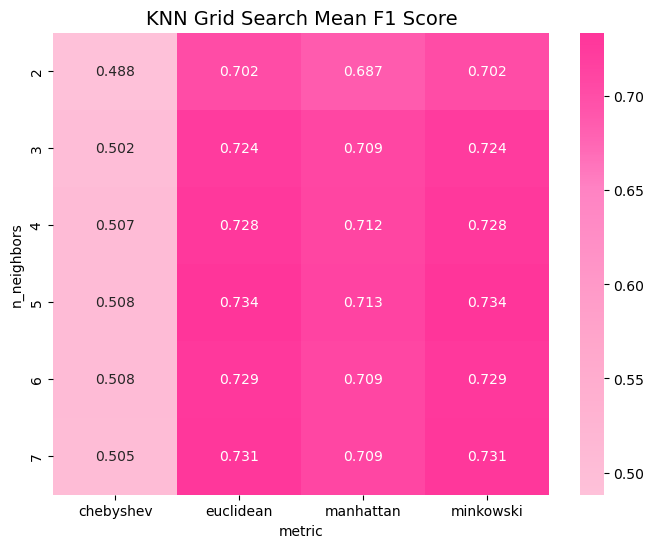

In [13]:
results = grid_knn.cv_results_
scores = results['mean_test_score']
params = results['params']

df = pd.DataFrame(params)
df['score'] = scores

df.columns = [col.replace('classifier__', '') for col in df.columns]

pivot = df.pivot(index='n_neighbors', columns='metric', values='score')

bubble_to_hot_pink = LinearSegmentedColormap.from_list(
    "bubble_to_hot_pink",
    ["#fec1d9", "#ffa6cb", "#ff82c3", "#ff0080ca"], 
    N=256 
)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap=bubble_to_hot_pink)
plt.title("KNN Grid Search Mean F1 Score", fontsize=14)
plt.ylabel("n_neighbors")
plt.xlabel("metric")
plt.show()

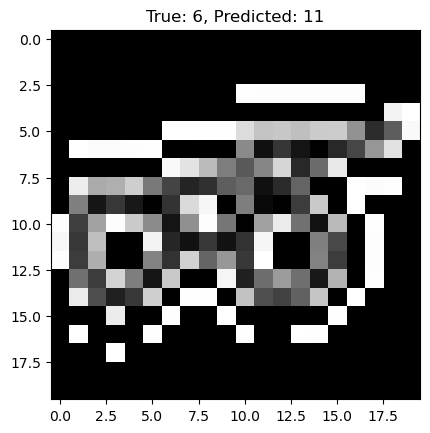

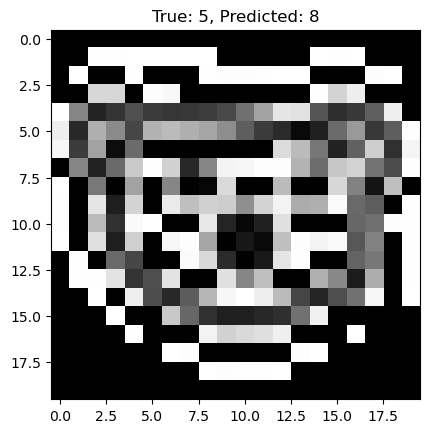

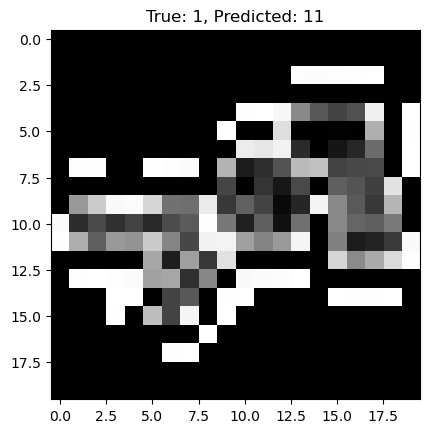

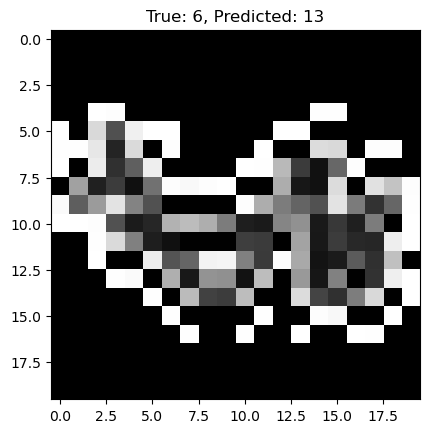

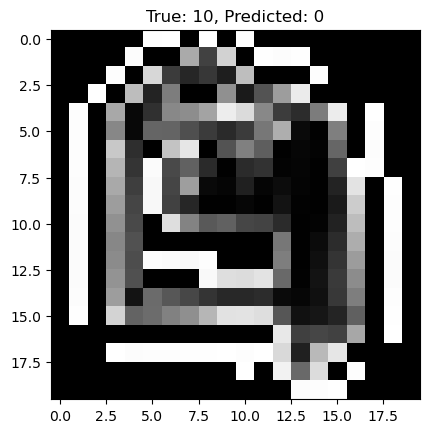

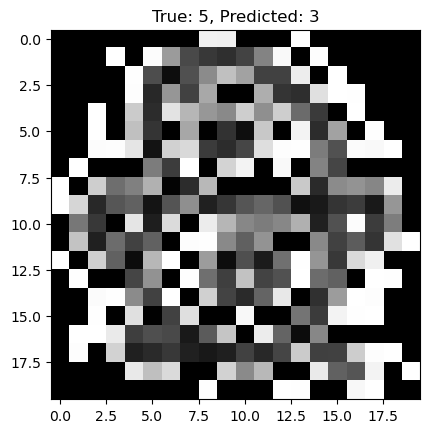

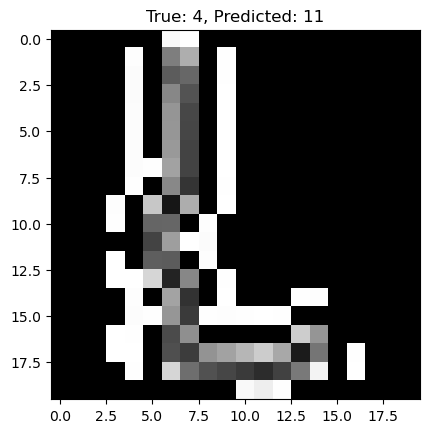

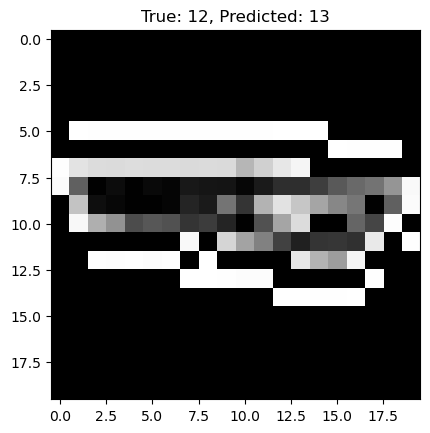

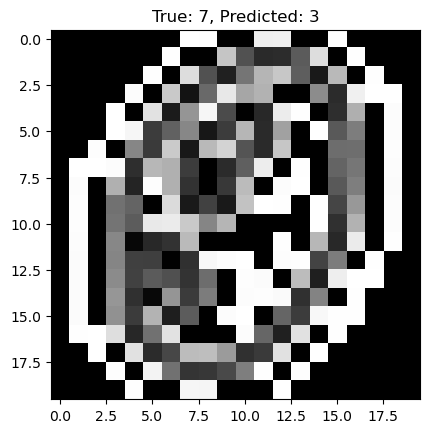

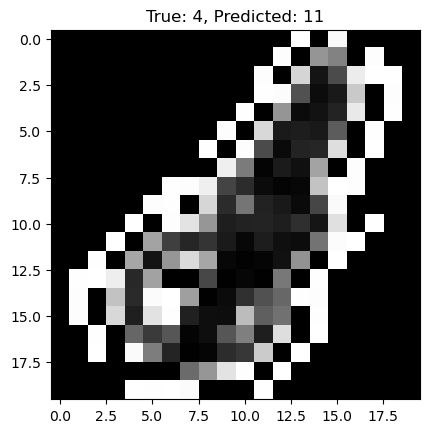

In [14]:
misclassified = np.where(y_pred != y_test)[0]

for idx in misclassified[:10]:
    img = x_test[idx].reshape(20, 20) * 255 
    plt.imshow(img, vmin=0, vmax=255, cmap="gray")
    plt.title(f"True: {y_test[idx]}, Predicted: {y_pred[idx]}")
    plt.show()

# Problem 2: running KNN with PCA

In [15]:
best_model_knn_pca, y_pred_pca, grid_knn_pca, score_pca, train_time_pca, pred_time_pca = knn_function(pca=True)

KNN training time: 76.7312 seconds
KNN prediction time: 0.1498 seconds
KNN Classifier score: 76.70%
--------------------------------------------------
Best number of neighbors (k): 5
Best distance metric: euclidean
Best PCA n_components: 0.7
--------------------------------------------------


##### Plotting score, training time and prediction time for KNN with and without PCA

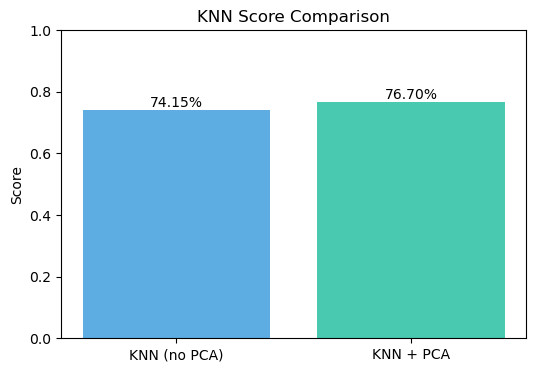

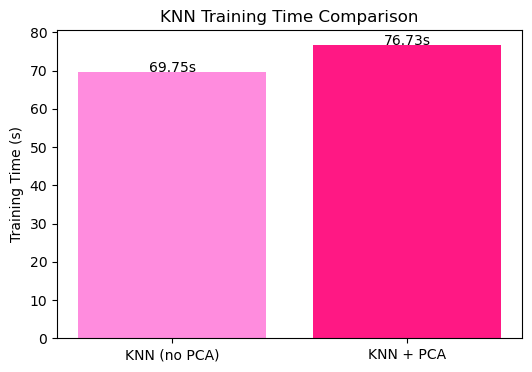

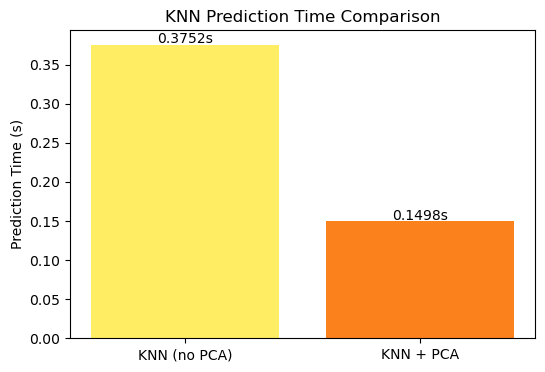

In [16]:
models = ['KNN (no PCA)', 'KNN + PCA']
scores = [score, score_pca]
train_times = [train_time, train_time_pca]
pred_times = [pred_time, pred_time_pca]

plt.figure(figsize=(6,4))
plt.bar(models, scores, color=['#5DADE2', '#48C9B0'])
plt.ylabel('Score')
plt.title('KNN Score Comparison')
for i, v in enumerate(scores):
    plt.text(i, v + 0.01, f"{v*100:.2f}%", ha='center')
plt.ylim(0, 1)
plt.show()

plt.figure(figsize=(6,4))
plt.bar(models, train_times, color=["#FF8CDE", "#FF1884"])
plt.ylabel('Training Time (s)')
plt.title('KNN Training Time Comparison')
for i, v in enumerate(train_times):
    plt.text(i, v + 0.02, f"{v:.2f}s", ha='center')
plt.show()

plt.figure(figsize=(6,4))
plt.bar(models, pred_times, color=["#FFED64", "#FB811D"])
plt.ylabel('Prediction Time (s)')
plt.title('KNN Prediction Time Comparison')
for i, v in enumerate(pred_times):
    plt.text(i, v + 0.002, f"{v:.4f}s", ha='center')
plt.show()


# Problem 3

In [17]:
corrupted_dataset = np.load("dataset_corrupted.npz")
X_corrupted = corrupted_dataset["X"] / 255
X_corrupted_tensor = torch.tensor(X_corrupted, dtype=torch.float32).view(-1, 1, 20, 20)
X_corrupted_tensor = X_corrupted_tensor.to(best_model.device)


best_model.model.eval()
with torch.no_grad():
    outputs = best_model.model(X_corrupted_tensor)  

max_probs = outputs.max(dim=1).values

threshold = 1

ood_indices = (max_probs < threshold).nonzero(as_tuple=True)[0].cpu().numpy()
print(f"Found {len(ood_indices)} suspicious/corrupted images")

Found 144 suspicious/corrupted images


##### Vizualising corrupted images

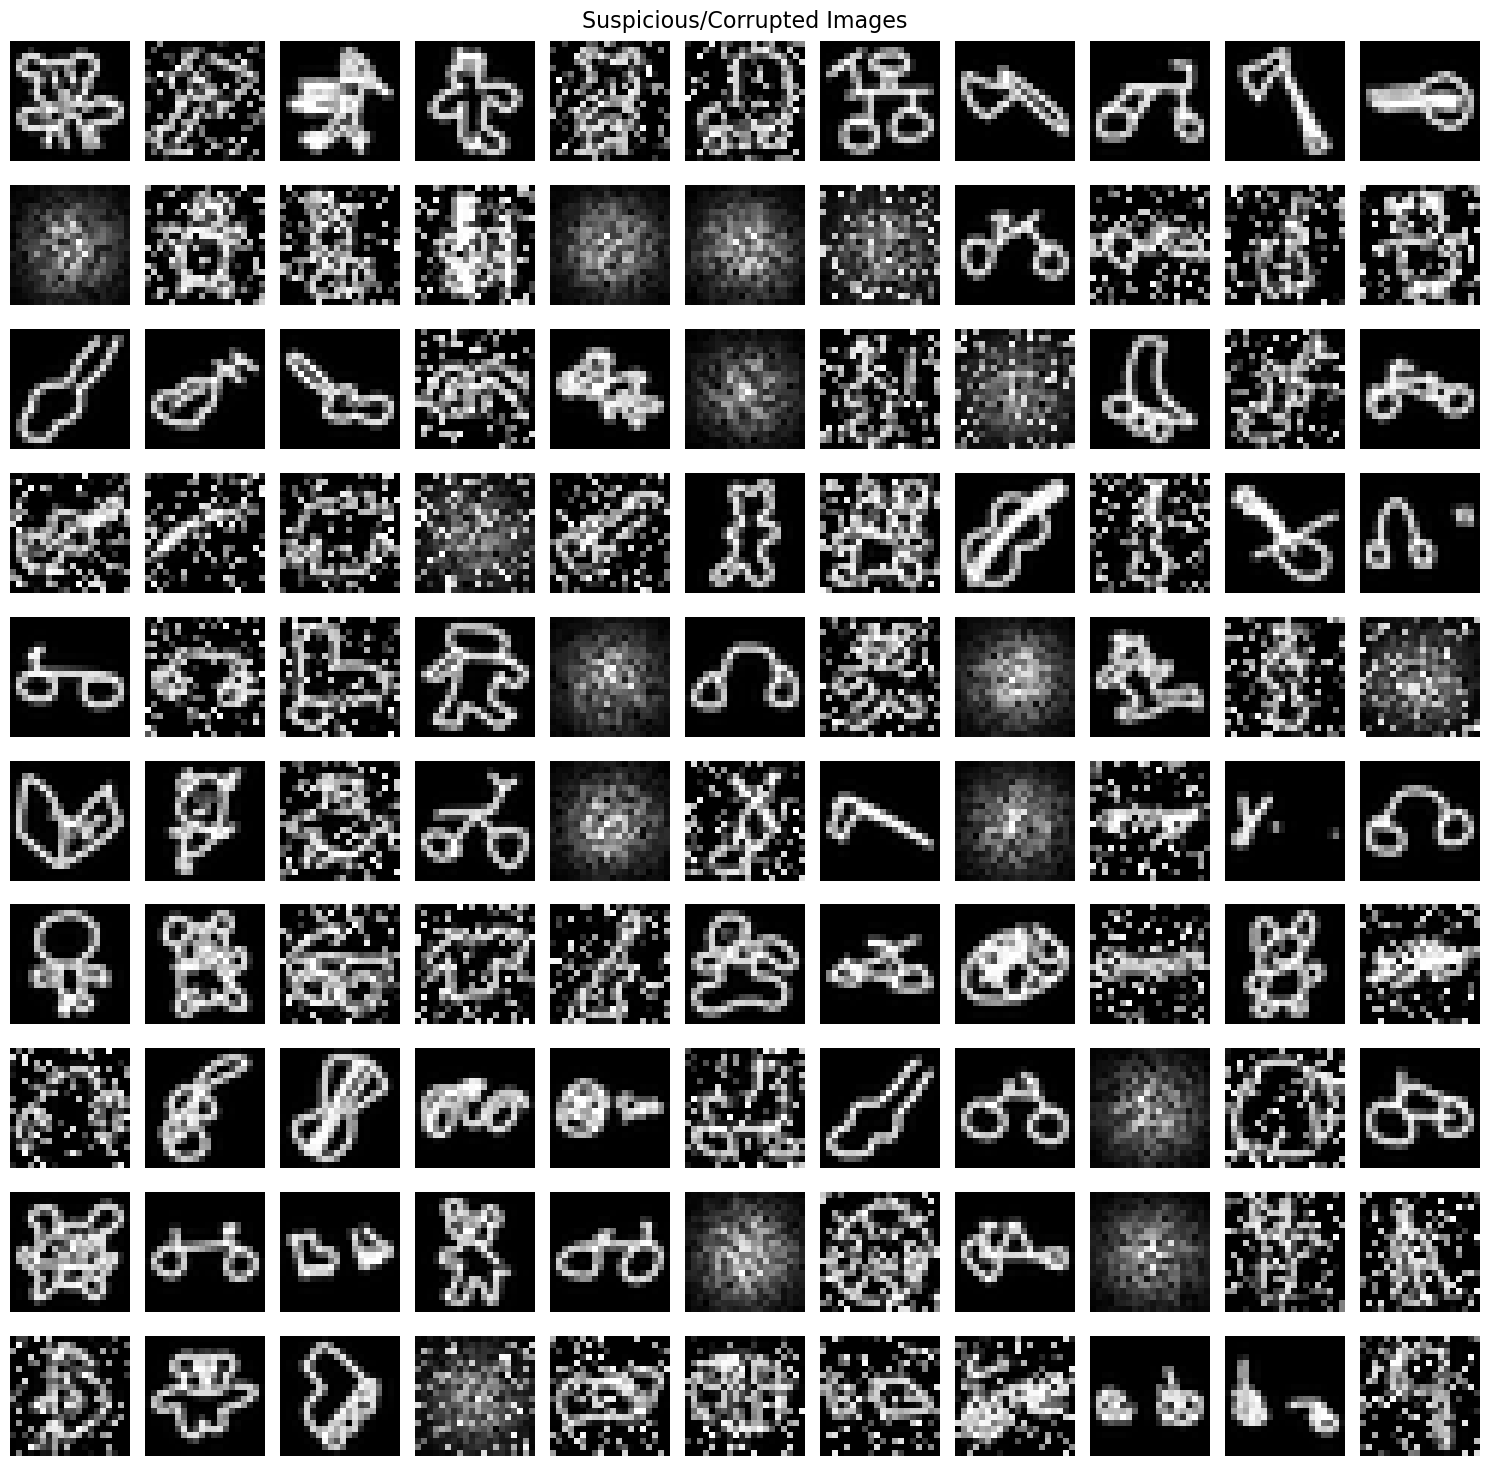

In [18]:
num_images = min(116, len(ood_indices))
grid_size = int(num_images**0.5)

fig, axes = plt.subplots(grid_size, grid_size+1, figsize=(15, 15))
fig.suptitle("Suspicious/Corrupted Images", fontsize=16)

for i, ax in enumerate(axes.flat):
    if i < num_images:
        idx = ood_indices[i]
        ax.imshow(corrupted_dataset["X"][idx].reshape(20, 20), cmap="gray")
    ax.axis('off')

plt.tight_layout()
plt.show()